# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [3]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [4]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
32245
Now saving the 200th result...
60540
Now saving the 300th result...
89501
Now saving the 400th result...
117329
Now saving the 500th result...
142547
Now saving the 600th result...
175695


#  

#### Reduce columns:

In [5]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

183813


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,Subdirectory,filename,station_code,station_number,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,1443.396226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,191.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.504032,405.660377,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,...,24,218.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.500000,1537.735849,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,24,33.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.650538,1490.566038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,83.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
136051,R014207941,1759-18,39.png,num,1.500000,378.846154,NaN,1.0,8.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53859,R014207822,3464-19A-2,134.png,num,4.056604,1636.170213,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152290,R014207950,2503-5-B,314.png,num,1.673387,1107.407407,NaN,0.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76493,R014207829,4270-46A,196.png,num2,1.641129,1344.230769,NaN,NaN,NaN,NaN,...,46.0,67.0,174.0,07,16.0,11.0,NaN,NaN,NaN,NaN
100292,R014207834,4489-43A,26.png,loss,1.907258,1200.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
81578,R014207830,3684-50A,147.png,loss,1.532258,2503.846154,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
175892,R014207969,1307-18B,281.png,num,1.500000,1082.000000,NaN,1.0,8.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98359,R014207834,4475-12,241.png,loss,1.729839,1752.631579,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
16519,R014207810,5131,165.png,loss,2.024194,1288.636364,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
16085,R014207810,5130,572.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 1807,width: 1550"


#  

#### Split results into different metadata types (dot, num, num2):

In [7]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'dot', 'num2'], dtype=object)

In [8]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

30212


In [9]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

46430


In [10]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

2504


In [11]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

18514


In [12]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

86153


In [13]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

183813

#### num2 - check timestamp components, construct timestamp:

In [14]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
32086,67.0,036,18.0,28.0,26.0
117915,65.0,156.0,12,51,56
118074,65.0,169.0,23.0,39,37
103016,66.0,13.0,08,21.0,09
115399,61.0,166.0,05,54,00
87085,67.0,306,0.0,34,10
115870,61,175,04,25,24
95153,68.0,39.0,11.0,18,08
112949,67,080,05,10,11
124364,61.0,247.0,22.0,51.0,25


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

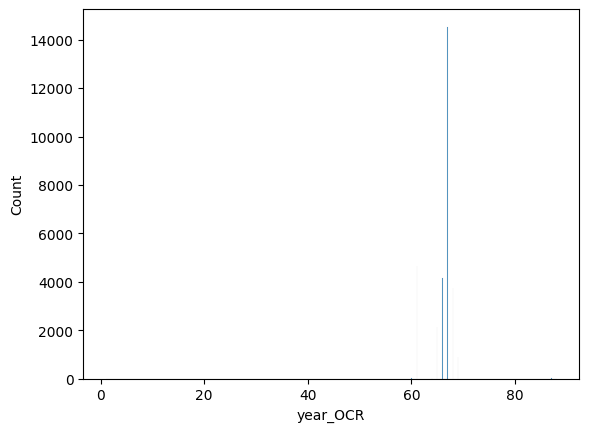

In [15]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [16]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [17]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
75475,1968.0,68.0
114015,1967.0,67.0
118116,1965.0,65.0
122878,NaN,NaN
94201,1967.0,67.0
101828,1965.0,65.0
43906,1969.0,69.0
95693,1967.0,67.0
80363,NaN,NaN
103710,1966.0,66.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

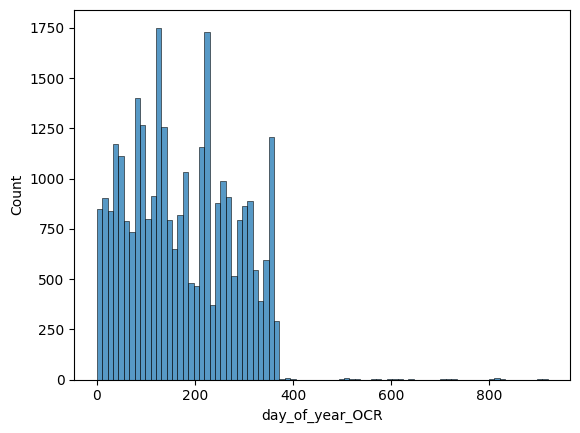

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [19]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
94427,355.0,355.0
39862,249.0,249.0
37851,293.0,293.0
105817,146.0,146.0
93716,354.0,354.0
34329,180.0,180.0
122436,179.0,179.0
125501,263.0,263.0
39855,249.0,249.0
126996,349.0,349.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

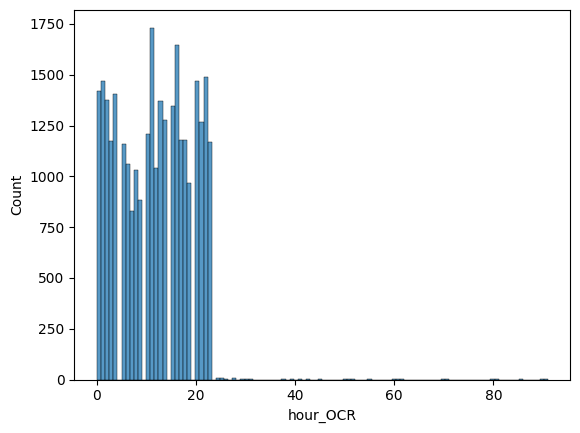

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [21]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
103637,12.0,12.0
95830,15.0,15.0
72651,2.0,2.0
90366,18.0,18.0
32451,11.0,11.0
106696,16.0,16.0
74996,6.0,6.0
117575,3.0,3.0
92897,16.0,16.0
117195,3.0,3.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

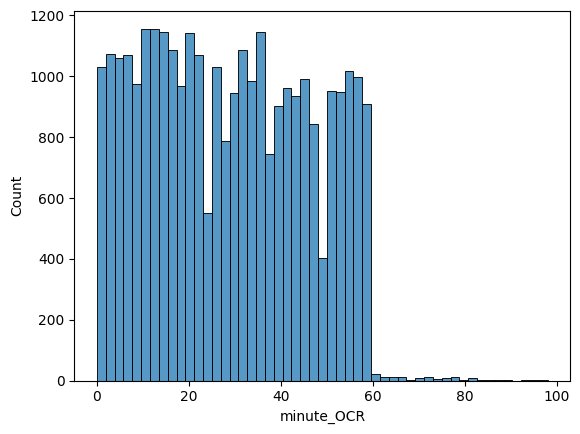

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [23]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
31785,15.0,15.0
118191,59.0,59.0
104166,26.0,26.0
65667,55.0,55.0
40017,43.0,43.0
125801,31.0,31.0
89132,48.0,48.0
36940,59.0,59.0
36265,58.0,58.0
87240,19.0,19.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

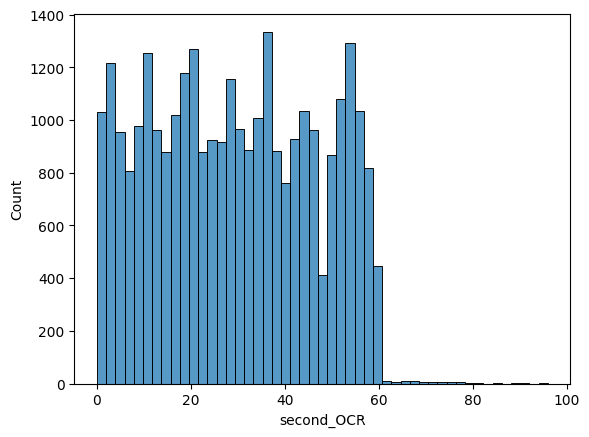

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [25]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
106953,39.0,39.0
38323,37.0,37.0
94504,58.0,58.0
39916,11.0,11.0
115818,42.0,42.0
87541,30.0,30.0
87532,24.0,24.0
34125,43.0,43.0
87462,52.0,52.0
92232,34.0,34.0


construct timestamp:

In [26]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

30212


In [27]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
87862,1967.0,02,19,23.0,39.0,58.0,1967-02-19 23:39:58,1
93735,1967.0,12,10,18.0,16.0,52.0,1967-12-10 18:16:52,1
126665,1967.0,11,04,22.0,11.0,25.0,1967-11-04 22:11:25,1
76593,NaN,06,27,8.0,6.0,49.0,NaT,0
39012,1967.0,10,28,12.0,17.0,8.0,1967-10-28 12:17:08,1
116143,NaN,07,03,15.0,40.0,29.0,NaT,0
32143,1967.0,02,12,17.0,26.0,50.0,1967-02-12 17:26:50,1
104891,1967.0,03,19,7.0,55.0,0.0,1967-03-19 07:55:00,1
91558,1967.0,05,04,20.0,34.0,31.0,1967-05-04 20:34:31,1
113406,1967.0,03,27,4.0,11.0,9.0,1967-03-27 04:11:09,1


#  

#### num - check timestamp components, construct timestamp:

In [28]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
82024,0.0,1.0,1.0,1.0,4.0,0.0,2.0,0.0,1.0,1.0
166663,4.0,0.0,7.0,2.0,0.0,8.0,4.0,7.0,0.0,8.0
167006,4.0,0.0,7.0,6.0,0.0,0.0,3.0,4.0,5.0,6.0
173460,3.0,2.0,3.0,0.0,1.0,0.0,0.0,9.0,5.0,0.0
151665,5.0,0.0,8.0,3.0,2.0,1.0,3.0,0.0,2.0,2.0
163401,3.0,2.0,7.0,4.0,1.0,5.0,5.0,1.0,3.0,1.0
141502,4.0,2.0,6.0,9.0,0.0,2.0,1.0,6.0,2.0,9.0
30159,8.0,3.0,3.0,2.0,2.0,2.0,6.0,0.0,6.0,5.0
54550,2.0,2.0,2.0,2.0,2.0,3.0,4.0,0.0,4.0,2.0
139857,4.0,2.0,4.0,3.0,0.0,0.0,4.0,2.0,4.0,2.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

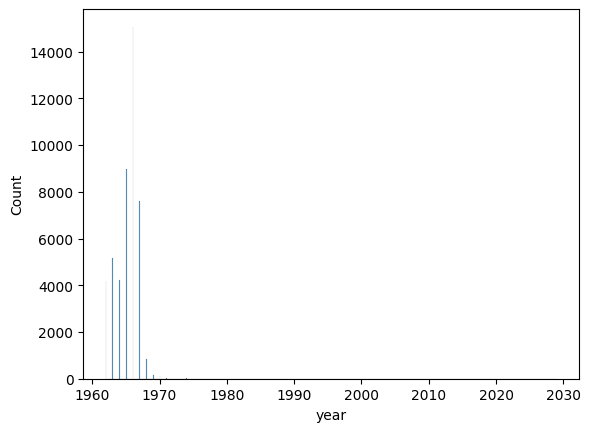

In [29]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [30]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
183556,1962.0,0.0
156920,1967.0,5.0
60702,1964.0,2.0
141664,1968.0,6.0
162946,1965.0,3.0
171247,1966.0,4.0
81960,1964.0,2.0
178011,1964.0,2.0
176981,1965.0,3.0
170926,1966.0,4.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

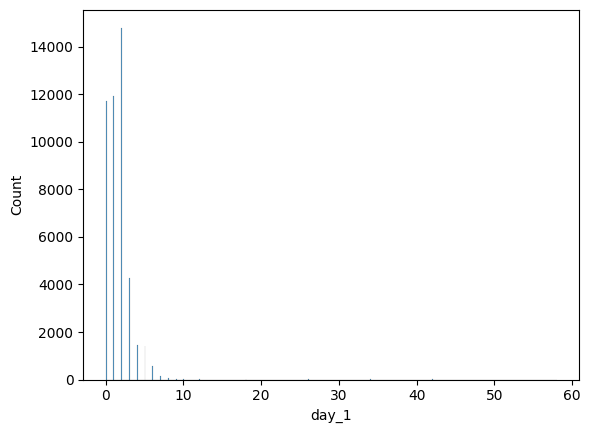

In [31]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [32]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

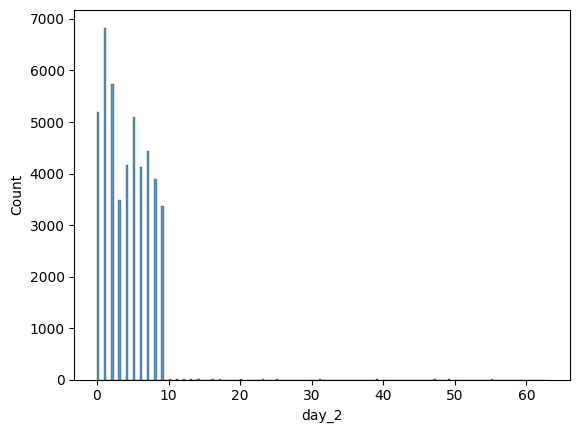

In [33]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [34]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

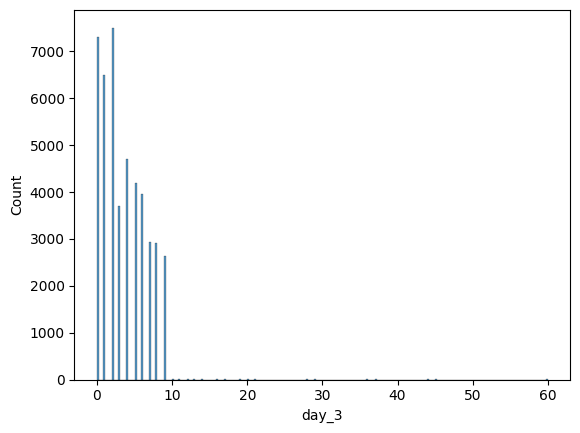

In [35]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [36]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [37]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

46430


,day_of_year,day_1,day_2,day_3
149286,48.0,0.0,4.0,8.0
175015,304.0,3.0,0.0,4.0
49526,224.0,2.0,2.0,4.0
138127,NaN,6.0,5.0,1.0
173839,243.0,2.0,4.0,3.0
153424,107.0,1.0,0.0,7.0
136464,156.0,1.0,5.0,6.0
80912,111.0,1.0,1.0,1.0
19130,NaN,0.0,0.0,0.0
143504,276.0,2.0,7.0,6.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

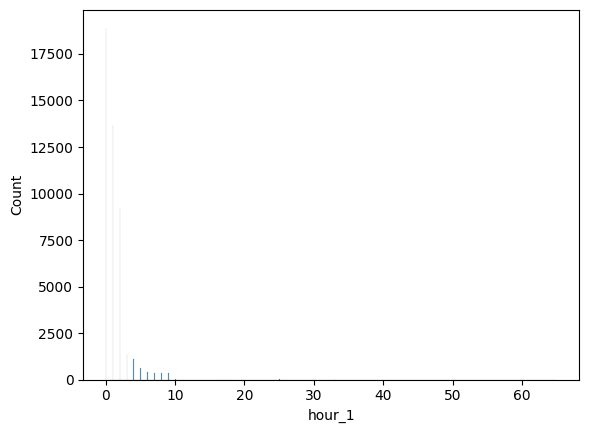

In [38]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [39]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

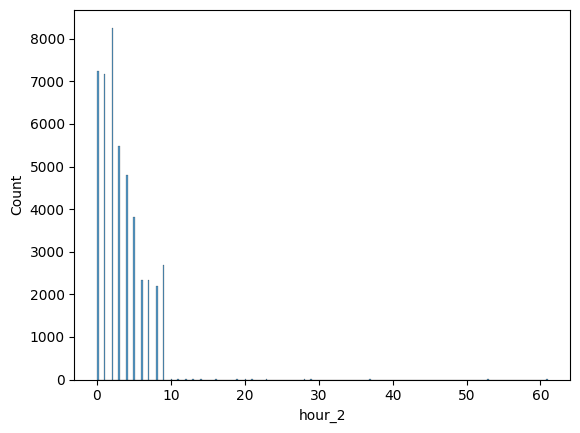

In [40]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [41]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [42]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

46430


,hour,hour_1,hour_2
162954,6.0,0.0,6.0
169456,6.0,0.0,6.0
136864,12.0,1.0,2.0
162877,19.0,1.0,9.0
169339,23.0,2.0,3.0
136462,9.0,0.0,9.0
167372,3.0,0.0,3.0
44920,11.0,1.0,1.0
135004,11.0,1.0,1.0
169602,21.0,2.0,1.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

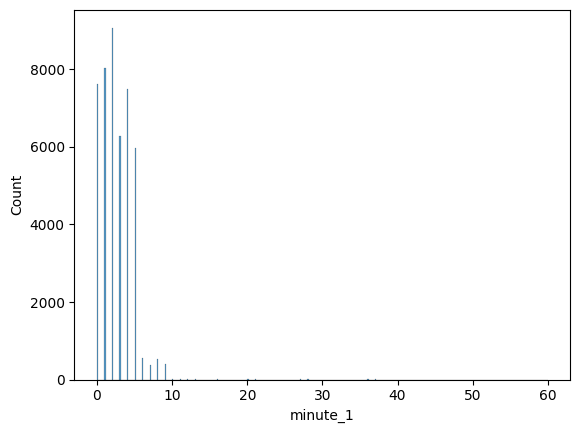

In [43]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [44]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

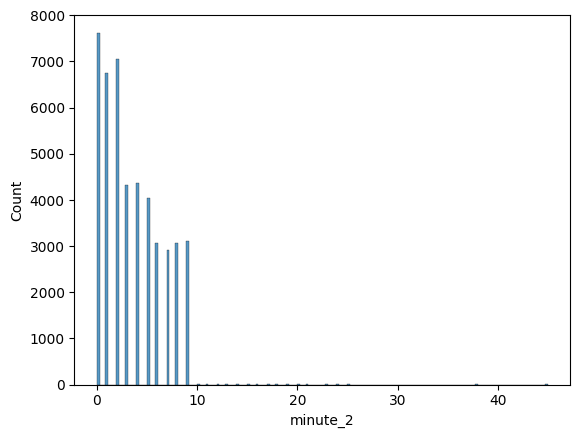

In [45]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [46]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [47]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

46430


,minute,minute_1,minute_2
170240,20.0,2.0,0.0
165859,13.0,1.0,3.0
29768,NaN,7.0,3.0
149105,48.0,4.0,8.0
166697,36.0,3.0,6.0
61301,2.0,0.0,2.0
141676,53.0,5.0,3.0
10216,46.0,4.0,6.0
62942,40.0,4.0,0.0
154535,3.0,0.0,3.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

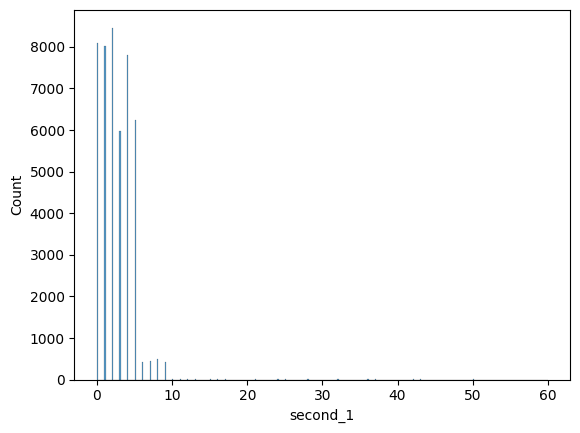

In [48]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [49]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

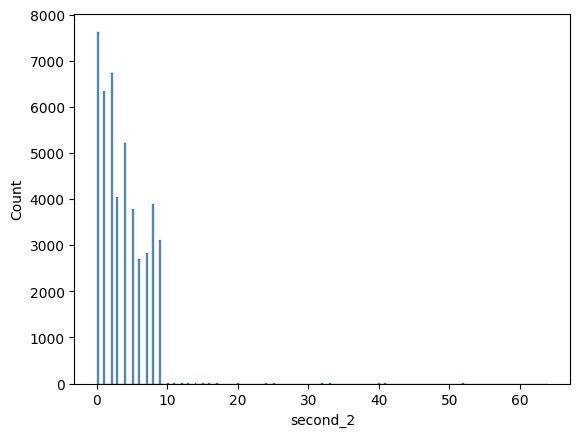

In [50]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [51]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [52]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

46430


,second,second_1,second_2
164892,0.0,0.0,0.0
136729,7.0,0.0,7.0
139523,15.0,1.0,5.0
144072,45.0,4.0,5.0
133737,10.0,1.0,0.0
139083,35.0,3.0,5.0
62923,42.0,4.0,2.0
160198,4.0,0.0,4.0
508,2.0,0.0,2.0
170392,8.0,0.0,8.0


construct timestamp:

In [53]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

46430


In [54]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
165704,1962.0,10,07,21.0,NaN,10.0,1962-10-07 21:00:00,3
155483,1963.0,NaN,NaN,NaN,12.0,NaN,NaT,0
157931,1968.0,02,13,19.0,57.0,58.0,1968-02-13 19:57:58,1
66563,1966.0,08,12,14.0,22.0,24.0,1966-08-12 14:22:24,1
175889,1965.0,05,13,5.0,39.0,32.0,1965-05-13 05:39:32,1
141714,1968.0,10,10,20.0,16.0,32.0,1968-10-10 20:16:32,1
144958,1962.0,07,29,NaN,NaN,0.0,1962-07-29 00:00:00,4
137258,1966.0,06,23,12.0,22.0,51.0,1966-06-23 12:22:51,1
160158,1965.0,07,13,14.0,19.0,24.0,1965-07-13 14:19:24,1
174141,1965.0,09,18,20.0,21.0,16.0,1965-09-18 20:21:16,1


#  

#### dot - check timestamp components, construct timestamp:

In [55]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
162309,NaN,1.0,8.0,0.0,1.0,9.0,8.0,8.0,0.0,0.0,NaN
158785,NaN,1.0,12.0,8.0,17.0,8.0,13.0,16.0,0.0,8.0,NaN
159468,NaN,1.0,8.0,0.0,18.0,8.0,9.0,1.0,8.0,8.0,NaN
161013,NaN,1.0,12.0,8.0,8.0,0.0,16.0,17.0,24.0,9.0,NaN
164623,NaN,2.0,8.0,0.0,18.0,8.0,8.0,2.0,2.0,0.0,NaN
162354,NaN,1.0,8.0,8.0,18.0,1.0,8.0,1.0,8.0,0.0,NaN
158724,NaN,1.0,8.0,0.0,8.0,0.0,8.0,0.0,16.0,1.0,NaN
159947,NaN,2.0,8.0,0.0,9.0,2.0,8.0,8.0,10.0,1.0,NaN
140823,NaN,2.0,8.0,0.0,2.0,0.0,8.0,8.0,8.0,2.0,NaN
162306,NaN,1.0,8.0,8.0,1.0,9.0,9.0,8.0,1.0,1.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

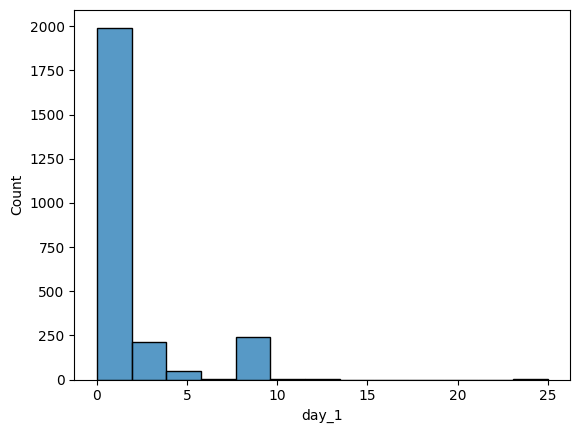

In [56]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [57]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

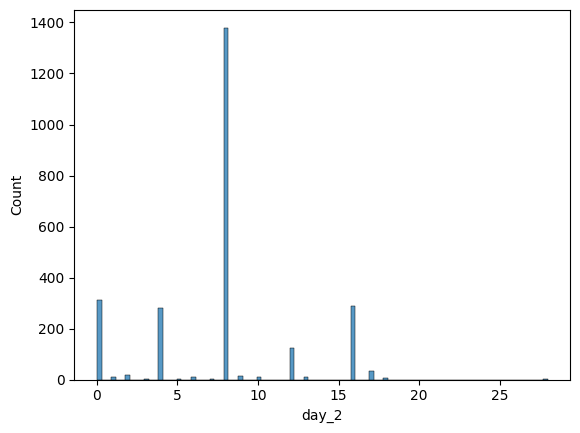

In [58]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [59]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

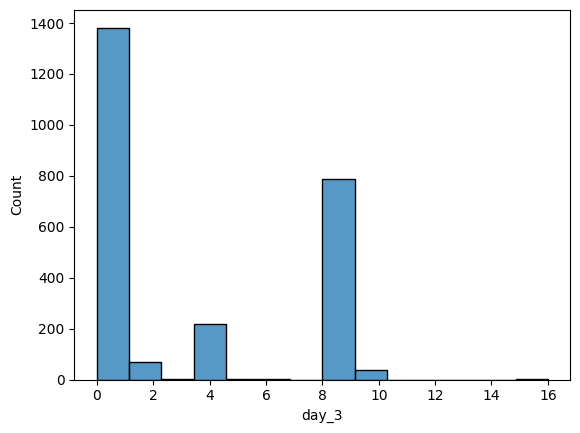

In [60]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [61]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [62]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

2504


,day_of_year,day_1,day_2,day_3
140897,NaN,8.0,0.0,0.0
158320,140.0,1.0,4.0,0.0
158783,188.0,1.0,8.0,8.0
158327,NaN,1.0,NaN,8.0
162116,NaN,1.0,NaN,8.0
159812,181.0,1.0,8.0,1.0
158864,180.0,1.0,8.0,0.0
162486,NaN,8.0,0.0,0.0
164470,180.0,1.0,8.0,0.0
159578,180.0,1.0,8.0,0.0


year - infer from day:

In [63]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_12656\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_12656\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963


,year,day_of_year,day_1,day_2,day_3
140937,1962.0,280.0,2.0,8.0,0.0
158469,1963.0,144.0,1.0,4.0,4.0
158841,1963.0,140.0,1.0,4.0,0.0
163104,NaN,NaN,8.0,0.0,0.0
140727,1963.0,189.0,1.0,8.0,9.0
162487,1963.0,180.0,1.0,8.0,0.0
163022,1963.0,180.0,1.0,8.0,0.0
161014,1963.0,198.0,1.0,9.0,8.0
159518,1963.0,180.0,1.0,8.0,0.0
163043,1963.0,140.0,1.0,4.0,0.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

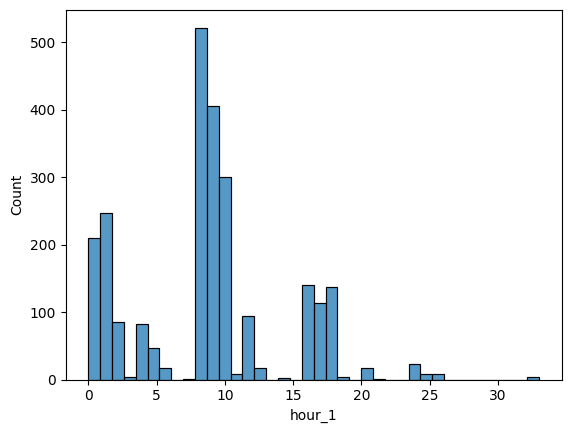

In [64]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [65]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

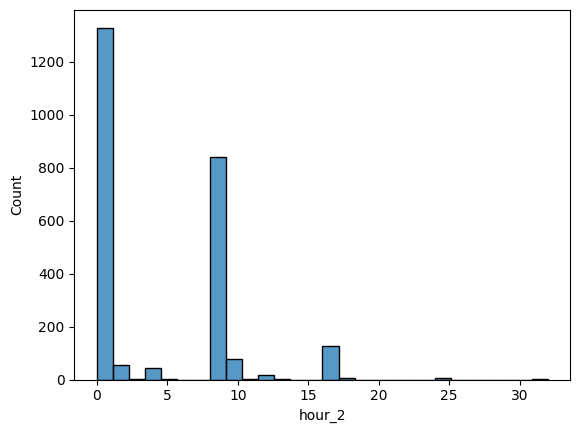

In [66]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [67]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [68]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

2504


,hour,hour_1,hour_2
162313,NaN,8.0,NaN
164486,NaN,8.0,8.0
160977,11.0,1.0,1.0
160949,NaN,9.0,0.0
140877,2.0,0.0,2.0
164489,NaN,8.0,NaN
160866,18.0,1.0,8.0
140822,9.0,0.0,9.0
158730,NaN,NaN,0.0
159517,NaN,NaN,8.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

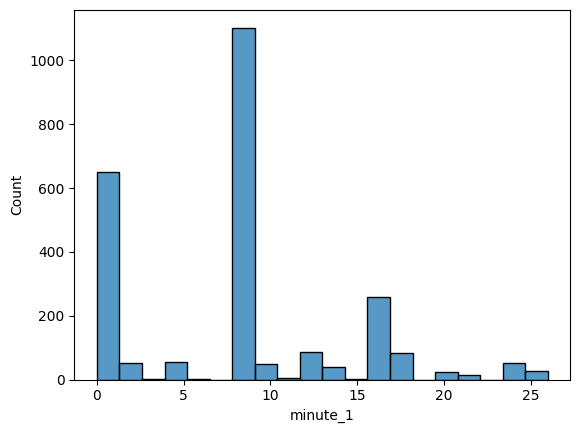

In [69]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [70]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

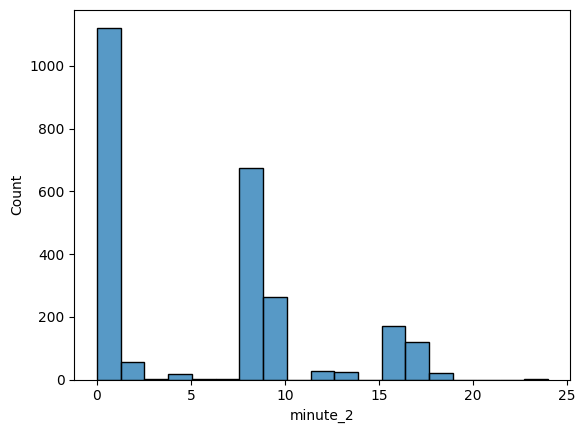

In [71]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [72]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [73]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

2504


,minute,minute_1,minute_2
162493,8.0,0.0,8.0
158855,NaN,8.0,1.0
162356,NaN,0.0,NaN
158370,NaN,NaN,0.0
162034,NaN,9.0,1.0
161011,NaN,NaN,NaN
161037,NaN,8.0,NaN
164577,NaN,8.0,1.0
159516,NaN,NaN,8.0
162061,8.0,0.0,8.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

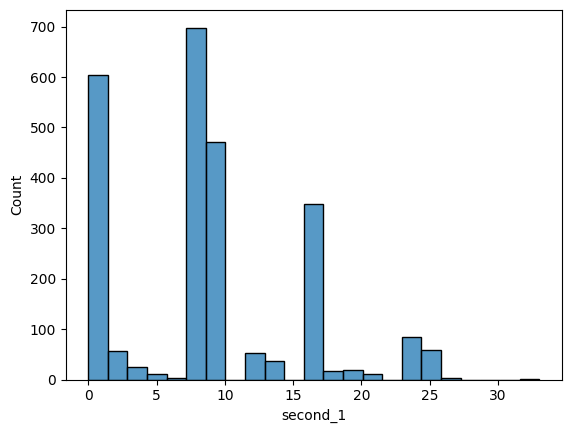

In [74]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [75]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

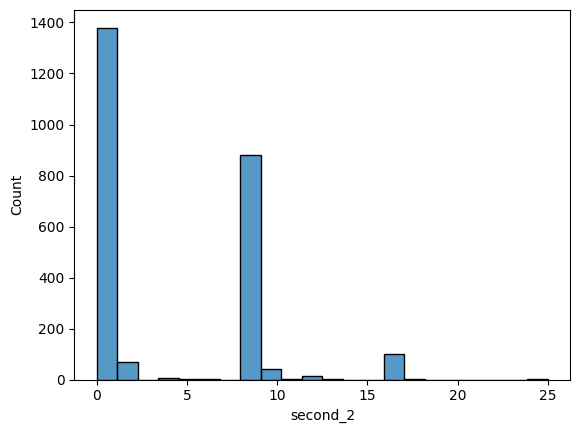

In [76]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [77]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [78]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

2504


,second,second_1,second_2
158926,NaN,8.0,1.0
162398,NaN,9.0,8.0
140825,0.0,0.0,0.0
162361,NaN,9.0,1.0
164592,NaN,8.0,1.0
158872,10.0,1.0,0.0
158534,NaN,8.0,NaN
162983,NaN,8.0,0.0
162197,NaN,9.0,9.0
161060,NaN,NaN,1.0


construct timestamp:

In [79]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

2504


In [80]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
164574,1962.0,10,07,NaN,NaN,NaN,1962-10-07 00:00:00,4
161960,1963.0,07,07,NaN,0.0,NaN,1963-07-07 00:00:00,4
158685,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
163151,NaN,NaN,NaN,9.0,10.0,NaN,NaT,0
162475,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
162016,1963.0,06,29,NaN,NaN,10.0,1963-06-29 00:00:00,4
158355,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
158411,1963.0,05,24,1.0,40.0,NaN,1963-05-24 01:40:00,2
159936,1962.0,10,09,NaN,NaN,22.0,1962-10-09 00:00:00,4
162329,1963.0,06,29,NaN,NaN,NaN,1963-06-29 00:00:00,4


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

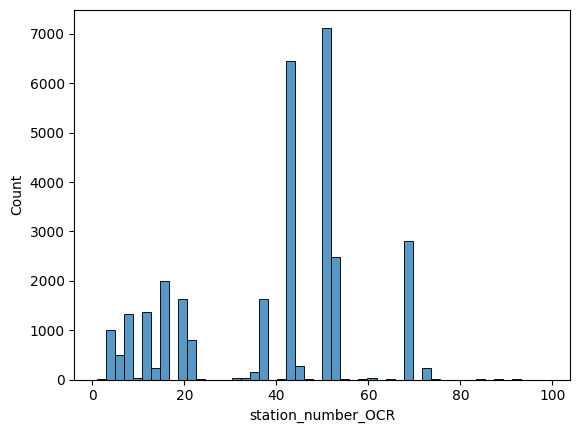

In [81]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [82]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
9821,50.0,50.0
90594,43.0,43.0
107632,69.0,69.0
31864,15.0,15.0
39660,38.0,38.0
90868,43.0,43.0
94466,50.0,50.0
123936,43.0,43.0
102504,53.0,53.0
123269,43.0,43.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

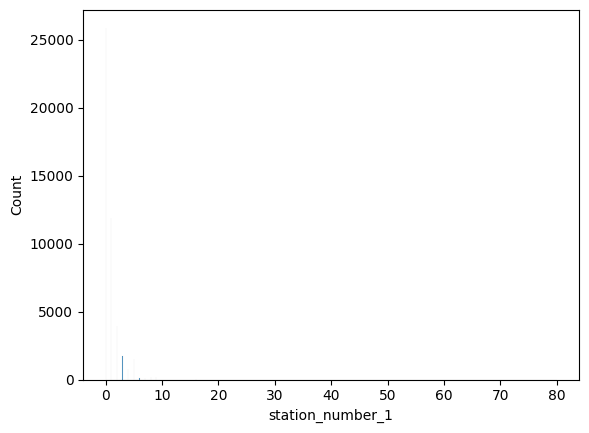

In [83]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [84]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

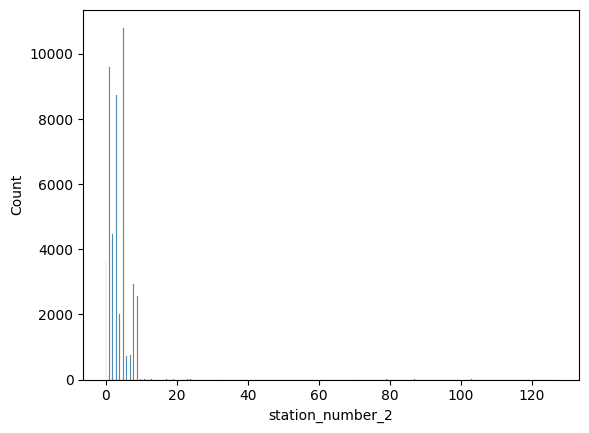

In [85]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [86]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [87]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

46430


,station_number,station_number_1,station_number_2
165023,1.0,0.0,1.0
171929,13.0,1.0,3.0
143350,13.0,1.0,3.0
54360,24.0,2.0,4.0
171636,13.0,1.0,3.0
138358,5.0,0.0,5.0
143064,30.0,3.0,0.0
81886,12.0,1.0,2.0
151950,8.0,0.0,8.0
167383,1.0,0.0,1.0


dot:

In [88]:
df_dot[['station_number']].sample(10)

,station_number
140785,17.0
140840,11.0
159518,17.0
164550,1.0
159396,9.0
162418,8.0
159947,9.0
160937,25.0
158352,13.0
162135,16.0


#  

#### Recombine results, save:

In [89]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

183813


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
169338,R014207963,1547-5A,103.png,num,1.782258,1386.538462,5.0,0.0,5.0,4.0,...,1966.0,84.0,23.0,5.0,29.0,1.0,03-25,03,25,1966-03-25 23:05:29
138554,R014207941,1798-5B,229.png,num,1.532258,1105.555556,5.0,0.0,5.0,4.0,...,1966.0,169.0,21.0,39.0,50.0,1.0,06-18,06,18,1966-06-18 21:39:50
171232,R014207963,1566-1B,244.png,num,1.500000,1242.000000,1.0,0.0,1.0,4.0,...,1966.0,71.0,1.0,1.0,11.0,1.0,03-12,03,12,1966-03-12 01:01:11
26528,R014207813,5005,180.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
26357,R014207813,5004,26.png,loss,5.157407,1466.666667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
153607,R014207950,2521-5-B,46.png,num,1.516129,1819.444444,5.0,0.0,5.0,5.0,...,1967.0,106.0,20.0,4.0,41.0,1.0,04-16,04,16,1967-04-16 20:04:41
7975,R014207808,4600-69-2,215.png,loss,4.433962,1404.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
80969,R014207830,3675-12A,181.png,num,1.612903,1429.787234,12.0,1.0,2.0,1.0,...,1963.0,211.0,11.0,21.0,21.0,1.0,07-30,07,30,1963-07-30 11:21:21
89957,R014207831,3935-43A,266.png,num2,1.963710,1295.652174,43.0,NaN,NaN,NaN,...,1967.0,5.0,2.0,33.0,29.0,1.0,01-05,01,05,1967-01-05 02:33:29
139151,R014207941,1806-5B,18.png,num,1.532258,1248.148148,5.0,0.0,5.0,4.0,...,1966.0,181.0,9.0,33.0,37.0,1.0,06-30,06,30,1966-06-30 09:33:37


Save:

In [90]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [91]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [92]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [93]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [94]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
2229
1963-04-25 00:00:00
5303
1963-08-06 00:00:00
7791
1965-07-01 00:00:00
13332
After 1965-07-01 00:00:00
68683


In [95]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [96]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

68683


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
53747,13.0,1967-05-06 13:04:50,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
39539,12.0,1966-05-20 07:38:14,NEW,"St. John's, NL, Canada",47.6N,52.4W
55617,1.0,1965-07-13 12:11:54,BPT,"Blossom Point, MD, USA",38.4N,77.1W
39599,12.0,1966-05-16 18:00:22,NEW,"St. John's, NL, Canada",47.6N,52.4W
8478,53.0,1965-06-10 01:03:09,KNO,"Kano, Nigeria",12N,8.5E
57031,7.0,1965-10-01 02:39:05,QUI,"Quito, Ecuador",0.6S,78.6W
50917,5.0,1967-03-16 23:30:34,QUI,"Quito, Ecuador",0.6S,78.6W
30286,19.0,1966-12-29 12:33:24,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
10880,NaN,1964-08-12 04:22:24,NaN,NaN,NaN,NaN
52533,5.0,1966-08-22 09:14:34,QUI,"Quito, Ecuador",0.6S,78.6W


#  

#### Save Master:

In [97]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

61560


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
45529,R014207944,2040-13B,206.png,num,1.500000,1001.923077,1968-10-15 16:11:14,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
30481,R014207835,4060-19,169.png,num2,1.508065,1168.085106,1967-03-23 01:22:02,1.0,19.0,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
36368,R014207839,4133-50A,10.png,num2,1.532258,906.122449,1967-09-27 15:45:37,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
35736,R014207839,4119-43A,177.png,num2,1.548387,1350.000000,1967-09-08 02:31:45,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
48387,R014207950,2469-3-A,174.png,num,1.500000,917.647059,1967-06-25 05:14:21,1.0,3.0,FTM,"Fort Myers, FL, USA",26.6N,81.9W
12134,R014207969,1306-18B,283.png,num,1.612903,1288.000000,1965-05-09 17:36:09,1.0,18.0,WNK,"Winkfield, England, UK",51.4N,0.4W
23347,R014207831,3932-43,239.png,num2,4.075472,1334.782609,1967-03-27 00:23:04,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
2864,R014207820,2973-5B,271.png,num,1.580645,1415.217391,1963-04-22 12:30:21,1.0,12.0,WOO,"Woomera, Australia",31.1S,136.8E
14436,R014207817,4148-15A,287.png,num2,1.705645,1400.000000,1967-01-13 08:00:12,1.0,15.0,WNK,"Winkfield, England, UK",51.4N,0.4W
42992,R014207944,1992-1A,8.png,num,1.750000,1300.000000,1966-09-12 01:05:05,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W


In [98]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)